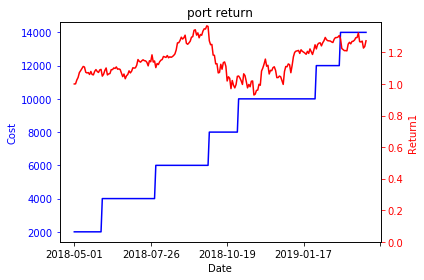

In [85]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
#import seaborn as sns; sns.set()

#------------------------------
#-- 0. Read in Asset_Daily
#------------------------------
team_df = pd.read_csv('TEAM.csv')
crm_df  = pd.read_csv('CRM.csv')

#------------------------------
#-- 1. Append PID AID
#------------------------------
def append_pid_aid(PID, AID, asset_df):
    q = """SELECT
          '{PID}' as PID
         ,'{AID}' as AID
         ,{asset_df}.*
        FROM
          {asset_df}
        ;""".format(PID=PID, AID=AID, asset_df=asset_df)
    asset_df = pysqldf(q)
    return asset_df
    
team_df = append_pid_aid(asset_df='team_df', AID='TEAM', PID='P1')
crm_df = append_pid_aid(asset_df='crm_df', AID='CRM', PID='P1')

#------------------------------
#-- 2. Asset Level Strategy
#------------------------------
# strategy, on day 1 of each month, buy qty = 1000/price of each asset
# double quote for field name w space... single quote for string

def app_strat(asset_df):
    q = """SELECT 
          {asset_df}.*
         ,strftime('%Y-%m-%d', Date) as YMD
         ,strftime('%d', Date) as day
         ,case 
            when strftime('%d', Date) = '01' then 1000/"Adj Close" else 0
          end as qty_chg_1
        FROM
          {asset_df}
        WHERE
          Date >= '2018-05-01'
        ORDER BY
          Date
        ;""".format(asset_df=asset_df)
    asset_df = pysqldf(q)
    return asset_df

team_df = app_strat(asset_df='team_df')
crm_df = app_strat(asset_df='crm_df')

#-----------------------------------------
#-- 3. Get market value, cost time series
#-----------------------------------------

def app_mv_cost(df, qty_chg_col, price_col, mv_col, cost_col, rtn1_col):
    df[mv_col] = df[qty_chg_col].cumsum() * df[price_col]
    df[cost_col] = (df[qty_chg_col]*df[price_col]).cumsum()
    df[rtn1_col] = df[mv_col]/df[cost_col]
    return df

def app_mv_cost2(df_in):
    df_out = app_mv_cost(df=df_in, 
                         qty_chg_col='qty_chg_1',
                         price_col='Adj Close',
                         mv_col='mv_1',
                         cost_col='cum_cost_1',
                         rtn1_col='return_1')
    return df_out


team_df = app_mv_cost2(df_in=team_df)
crm_df = app_mv_cost2(df_in=crm_df)

#------------------------------
#-- 4. Stack Assets
#------------------------------

q = """SELECT * FROM team_df
       UNION
       SELECT * FROM crm_df
    ;"""
assets_df = pysqldf(q)
assets_df.to_csv('assets.csv',index=False) # Save assets_df
# ref code: pd.concat([df1, df2])

#------------------------------
#-- 5. PORT DF
#------------------------------

q = """SELECT 
      PID, YMD
     ,sum({mv_col}) as {mv_col}
     ,sum({cost_col}) as {cost_col}
     ,sum({mv_col})/sum({cost_col}) as {rtn1_col}
    FROM 
      assets_df
    GROUP BY
      PID, YMD
    ORDER BY
      PID, YMD
    ;""".format(mv_col='mv_1',cost_col='cum_cost_1',rtn1_col='return1_1')
port_df = pysqldf(q)

#------------------------------
#-- 6. Visualization
#------------------------------
# plot cost, return
# will see if need price to QC

def get_chart(df, cost_col, return_col):
    
    x1 = df['YMD']
    y1 = df[cost_col]
    y2 = df[return_col]

    fig, ax1 = plt.subplots()

    #-- y1(cost)
    ax1.plot(x1, y1, color='b') # y1(cost)

    #-- Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Cost', color='b')
    ax1.tick_params('y', colors='b')

    #-- y2(return1)
    ax2 = ax1.twinx()
    ax2.plot(x1, y2, color='r') # y2(return1)
    ax2.set_ylim([0,None])
    
    #-- Make the y-axis label, ticks and tick labels match the line color.
    ax2.set_ylabel('Return1', color='r')
    ax2.tick_params('y', colors='r')

    #-- x1(date)
    plt.xticks(x1) # x1(Date)
    ax1.set_xlabel('Date')

    #-- set max xaxis n ticks
    ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
    
    #-- plot title
    plt.title('port return')

    plt.tight_layout()
    plt.show()
    
get_chart(df=port_df, cost_col='cum_cost_1', return_col='return1_1')